In [2]:
from io import open
import glob
import os
import unicodedata
import string


all_letters = string.ascii_letters + ".,;'-"
n_letters = len(all_letters) + 1

def findFiles(path): return glob.glob(path)

#turn unicode string to ascii
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD',s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

def readLines(filename):
    with open(filename,encoding='utf-8') as some_file:
        return [unicodeToAscii(line.strip()) for line in some_file]

# build category_lines dictionary, a list of lines per category
category_lines = {}
all_categories = []
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. make sure you downloaded it!')
print("# categories:", n_categories, all_categories)
print(unicodeToAscii("João"))

# categories: 18 ['Polish', 'German', 'Greek', 'Czech', 'French', 'Japanese', 'Scottish', 'English', 'Chinese', 'Korean', 'Dutch', 'Spanish', 'Vietnamese', 'Portuguese', 'Italian', 'Russian', 'Irish', 'Arabic']
Joao


In [3]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super(RNN,self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size,hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size,output_size)
        self.o2o = nn.Linear(hidden_size + output_size,output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category,input,hidden),1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden,output),1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output,hidden
    
    def initHidden(self):
        return torch.zeros(1,self.hidden_size)


In [4]:
import random

def randomTrainingPair():
    category = random.choice(all_categories)
    line = random.choice(category_lines[category])
    return category,line


In [5]:
#one hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1,n_categories)
    tensor[0][li] = 1
    return tensor

#one hot matrix of first to last letters for input
def inputTensor(line):
    tensor = torch.zeros(len(line),1,n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# it misses the first character
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1,len(line))]
    letter_indexes.append(n_letters - 1) #EOS
    return torch.LongTensor(letter_indexes)


In [6]:
#make category, input, and target from random category, line pair
def randomTrainingExample():
    category,line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor,input_line_tensor,target_line_tensor

In [7]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s/60)
    s -= m * 60
    return f"{m}m {s}s"

In [8]:
rnn = RNN(n_letters, 128,n_letters)
n_iters = 100000
print_every = 5000
save_every = 33000
plot_every = 500
all_losses = []
total_loss = 0

In [9]:
criterion = nn.NLLLoss()
learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()
    rnn.zero_grad()

    loss = torch.Tensor([0]) # u can also just use loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor,input_line_tensor[i],hidden)
        l = criterion(output,target_line_tensor[i])
        loss += l
    
    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data,alpha=-learning_rate)
    
    return output, loss.item() / input_line_tensor.size(0)

In [10]:
start = time.time()

for iter in range(1,n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print(f'{timeSince(start)} ({iter} {iter/n_iters * 100}%) {loss:>.4f}')
    
    if iter % plot_every == 0:
        all_losses.append(total_loss/plot_every)
        total_loss = 0

    if iter % save_every == 0:
        torch.save(rnn,f'modelos/model{iter}.pth')

0m 7.233880043029785s (5000 5.0%) 2.1946
0m 14.294437646865845s (10000 10.0%) 3.4101
0m 21.41238570213318s (15000 15.0%) 3.0012
0m 28.56778311729431s (20000 20.0%) 2.7847
0m 36.110098123550415s (25000 25.0%) 2.6971
0m 43.23392367362976s (30000 30.0%) 1.9221
0m 50.27430486679077s (35000 35.0%) 2.3963
0m 57.395801067352295s (40000 40.0%) 3.5747
1m 4.568399429321289s (45000 45.0%) 1.7782
1m 12.229755401611328s (50000 50.0%) 3.4062
1m 20.263721704483032s (55000 55.00000000000001%) 1.8089
1m 27.655418395996094s (60000 60.0%) 2.0241
1m 35.10193848609924s (65000 65.0%) 2.4810
1m 42.62185478210449s (70000 70.0%) 2.6947
1m 49.718900203704834s (75000 75.0%) 2.2951
1m 56.818384408950806s (80000 80.0%) 3.3823
2m 4.324218034744263s (85000 85.0%) 2.7210
2m 11.972995519638062s (90000 90.0%) 2.1969
2m 19.200725555419922s (95000 95.0%) 2.1617
2m 26.402265787124634s (100000 100.0%) 2.4263


In [14]:
torch.save(rnn,f'modelos/model{100000}.pth')

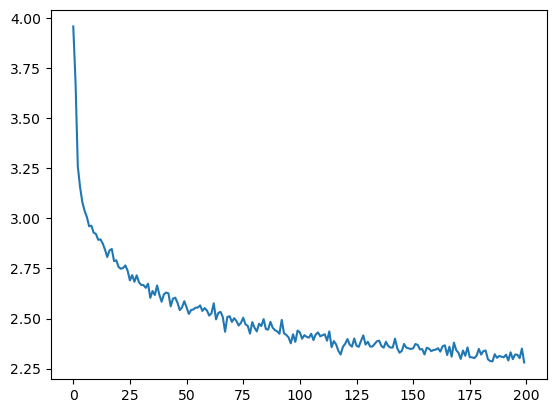

In [11]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)

In [12]:
max_length = 20

#sample from a category and starting letter

def sample(category,start_letter='H'):
    with torch.no_grad():
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for _ in range(max_length):
            output, hidden = rnn(category_tensor,input[0],hidden)
            topv, topi = output.topk(1) #picks top 1 in output lettrs
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)
        
        return output_name

def samples(category,start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category,start_letter))

In [18]:
samples('German','A')

Arter
